# Function Generator + Oscilloscope Demo

Start by importing the package, opening a resource manager, and printing the available resources

In [1]:
import time
import pyvisa
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
rm = pyvisa.ResourceManager()
rm.list_resources()

()

# Connect to the instruments

Enter the IP address, open the resource, query for confirmation

In [3]:
wavegen_ip = '192.168.1.2'
wavegen = rm.open_resource(f'TCPIP0::{wavegen_ip}::INSTR')

oscope_ip = '192.168.1.3'
oscope = rm.open_resource(f'TCPIP0::{oscope_ip}::INSTR')

In [4]:
wavegen.query('*IDN?')

'Siglent Technologies,SDG2082X,SDG2XFBX7R1251,2.01.01.37R6\n'

In [5]:
oscope.query('*IDN?')

'Siglent Technologies,SDS1104X-E,SDSMMFCX6R6004,8.3.6.1.37R8\n'

# Basic Wave

Set wave type

In [6]:
wave_type = 'SINE'
wavegen.write(f'C1:BSWV WVTP,{wave_type}')

19

Set wave frequency

In [7]:
freq = 5e3
wavegen.write(f'C1:BSWV FRQ,{freq}')

20

Set wave amplitude

In [8]:
amp = 1 # volt peak-to-peak
wavegen.write(f'C1:BSWV AMP,{amp}')

15

Turn the channel 1 output on

In [9]:
wavegen.write('C1:OUTP ON')

12

# Basic Data Capture

In [10]:
import siglent_sds1104xe_oscope as scope_funcs

In [11]:
T, t, data = scope_funcs.capture_data(oscope)

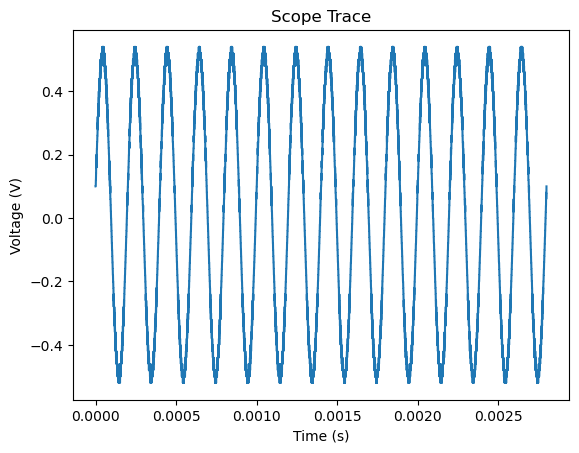

In [12]:
fig, ax = plt.subplots()

ax.set(xlabel='Time (s)', ylabel='Voltage (V)', title='Scope Trace')
ax.plot(t, data)

# Functions for waveform generator

and an fft function

In [13]:
def set_wave_type(inst, channel, wave_type):
    """ Set the waveform type using the Basic Wave command.

    :param inst: PyVisa resource object corresponding to the waveform generator.
    :param channel: (int) Channel on which to change the waveform type.
    :param wave_type: (str) one of ['SINE', 'SQUARE', 'RAMP', 'PULSE', 'ARB', 'DC', 'PRBS', 'IQ']
    """
    # - should error check here - #
    cmd = f'C{channel}:BSWV WVTP,{wave_type}'
    inst.write(cmd)

def set_frequency(inst, channel, freq):
    """ Set the waveform fundamental frequency.
    
    :param inst: PyVisa resource object corresponding to the waveform generator.
    :param channel: (int) Channel on which to change the waveform type.
    :param freq: COMPLETE THIS
    """
    cmd = f'C{channel}:BSWV FRQ,{freq}'
    inst.write(cmd)

def set_amplitude(inst, channel, amp):
    """ Set the waveform amplitude in peak-to-peak units.

    :param inst: PyVisa resource object corresponding to the waveform generator.
    :param channel: (int) Channel on which to change the waveform type.
    :param amp: COMPLETE THIS
    """
    cmd = f'C{channel}:BSWV AMP,{amp}'
    inst.write(cmd)

def set_channel_state(inst, channel, state):
    """ Set the state of a waveform generator channel to ON or OFF.

    :param inst: Pyvisa resource.
    :param channel: Waveform channel.
    :param state: 'ON' or 'OFF' to specify the state.
    """
    cmd = f'C{channel}:OUTP {state}'
    inst.write(cmd)

FFT function

In [14]:
def simple_fft(tsample, x):
    """
    Performs a positive-frequency FFT and returns the magnitude 

    :param tsample: float, sample time in seconds 
    :param x: array-like, data to FFR 
    
    :return f: np.array, frequency array in Hz 
    :return y: np.array, array of FFT magnitudes
    """
    N = len(x) 
    y = np.fft.fft(x) 
    y = 2 * np.abs(y) / N 
    # factor of 2 because signal is split equally between 
    # negative and positive frequency
    f = np.fft.fftfreq(N, d = tsample) 
    f, y = f[:N // 2], y[:N // 2]
    return f, y

Start with the channel turned off

In [15]:
set_channel_state(wavegen, 1, 'OFF')

### FFT a sine wave

In [16]:
set_wave_type(wavegen, 1, 'SINE')
set_frequency(wavegen, 1, 5e3)
set_amplitude(wavegen, 1, 2)
set_channel_state(wavegen, 1, 'ON')

In [17]:
T, t, data = scope_funcs.capture_data(oscope)
f, fft_data = simple_fft(T, data)

set_channel_state(wavegen, 1, 'OFF')

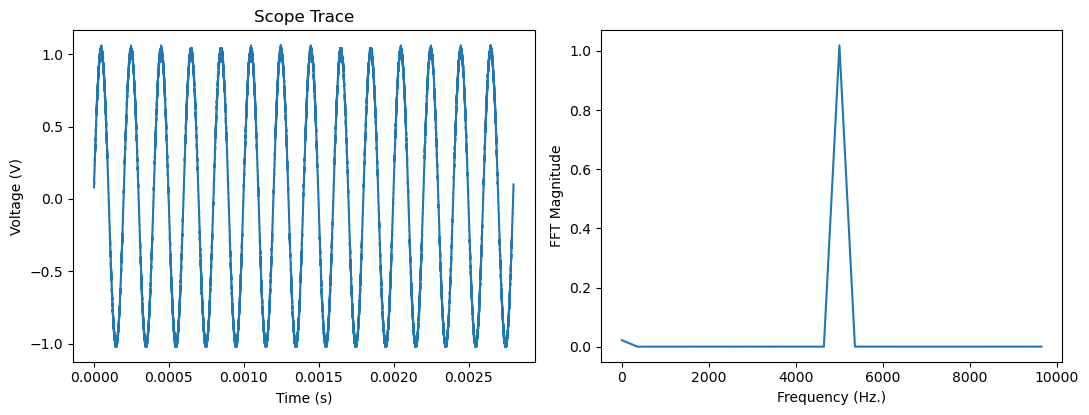

In [18]:
figsize = (11, 8.5/2)
fig, axs = plt.subplots(1, 2, figsize=figsize)
t_ax, f_ax = axs

# - set plot labels - #
t_ax.set(xlabel='Time (s)', ylabel='Voltage (V)', title='Scope Trace')
f_ax.set(xlabel='Frequency (Hz.)', ylabel='FFT Magnitude')

# - plot - #
t_ax.plot(t, data)

start_f = 0
end_f = 10e3
start_ind = np.argmin(np.abs(f - start_f))
end_ind = np.argmin(np.abs(f - end_f))
f_ax.plot(f[start_ind:end_ind], fft_data[start_ind:end_ind])

fig.tight_layout()

### FFT a square wave

In [19]:
# - set wave parameters, take data - #
set_wave_type(wavegen, 1, 'SQUARE')
set_frequency(wavegen, 1, 1e3)
set_amplitude(wavegen, 1, 2)
set_channel_state(wavegen, 1, 'ON')
T, t, data = scope_funcs.capture_data(oscope)
f, fft_data = simple_fft(T, data)

set_channel_state(wavegen, 1, 'OFF')

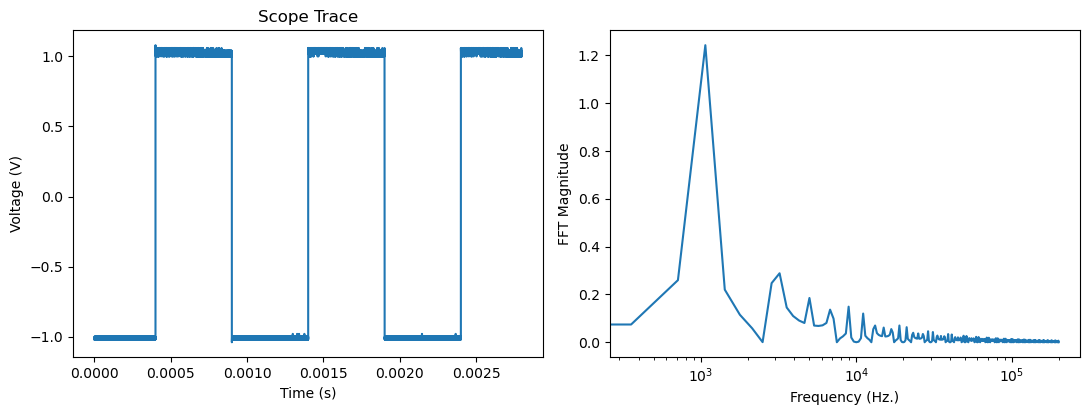

In [20]:
figsize = (11, 8.5/2)
fig, axs = plt.subplots(1, 2, figsize=figsize)
t_ax, f_ax = axs

# - set plot labels - #
t_ax.set(xlabel='Time (s)', ylabel='Voltage (V)', title='Scope Trace')
f_ax.set(xlabel='Frequency (Hz.)', ylabel='FFT Magnitude', xscale='log')

# - plot - #
t_ax.plot(t, data)

start_f = 0
end_f = 200e3
start_ind = np.argmin(np.abs(f - start_f))
end_ind = np.argmin(np.abs(f - end_f))
f_ax.plot(f[start_ind:end_ind], fft_data[start_ind:end_ind])
# f_ax.plot(f, fft_data)

fig.tight_layout()

### FFT of Ramp

In [21]:
# - set wave parameters, take data - #
set_wave_type(wavegen, 1, 'Ramp')
set_frequency(wavegen, 1, 1e3)
set_amplitude(wavegen, 1, 2)
set_channel_state(wavegen, 1, 'ON')
T, t, data = scope_funcs.capture_data(oscope)
f, fft_data = simple_fft(T, data)

set_channel_state(wavegen, 1, 'OFF')

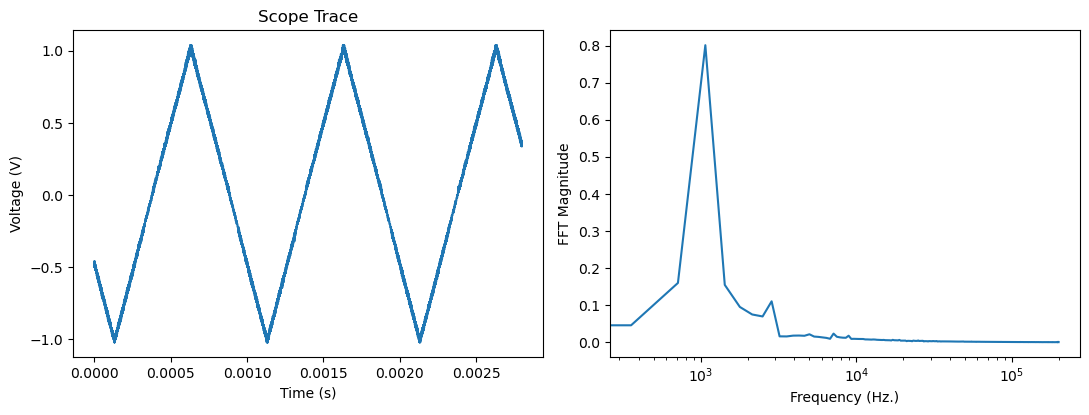

In [22]:
figsize = (11, 8.5/2)
fig, axs = plt.subplots(1, 2, figsize=figsize)
t_ax, f_ax = axs

# - set plot labels - #
t_ax.set(xlabel='Time (s)', ylabel='Voltage (V)', title='Scope Trace')
f_ax.set(xlabel='Frequency (Hz.)', ylabel='FFT Magnitude', xscale='log')

# - plot - #
t_ax.plot(t, data)

start_f = 0
end_f = 200e3
start_ind = np.argmin(np.abs(f - start_f))
end_ind = np.argmin(np.abs(f - end_f))
f_ax.plot(f[start_ind:end_ind], fft_data[start_ind:end_ind])
# f_ax.plot(f, fft_data)

fig.tight_layout()

# Modify oscilloscope X-Scale

Notice that our FFTs are not very clean in the last two examples. This is because we are not sampling enough periods of the waveforms.
We should modify the x-scale of the oscilloscope to sample more periods of the waveforms and obtain cleaner FFTs.

In [23]:
def set_xscale(inst, xscale):
    """
    Sets the horizontal scale

    :param inst: pyvisa resource
    :param xscale: float, horizontal scale in seconds / div
    """
    inst.write(f'TIME_DIV {xscale}s') 

In [24]:
# - set oscilloscope parameters - #
wave_freq = 1e3
xscale = 1 / wave_freq
set_xscale(oscope, xscale)

# - set wave parameters, take data - #
set_wave_type(wavegen, 1, 'SQUARE')
set_frequency(wavegen, 1, wave_freq)
set_amplitude(wavegen, 1, 2)
set_channel_state(wavegen, 1, 'ON')
T, t, data = scope_funcs.capture_data(oscope)
f, fft_data = simple_fft(T, data)

set_channel_state(wavegen, 1, 'OFF')

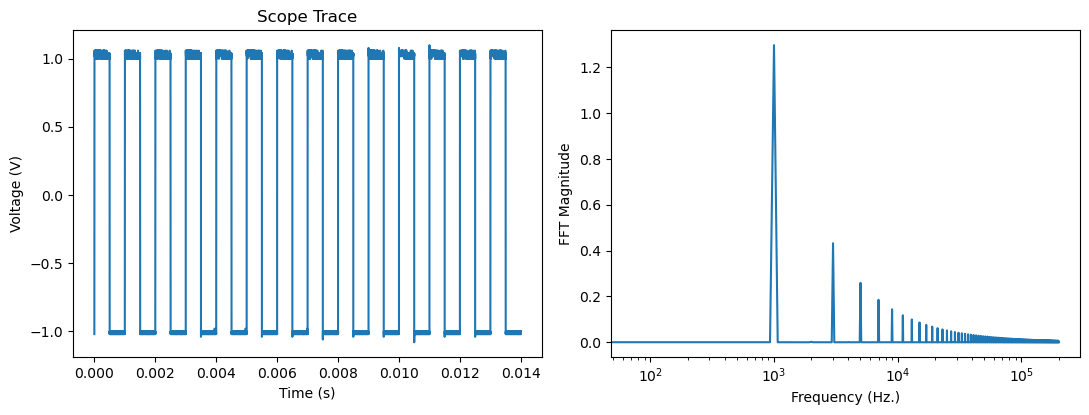

In [25]:
figsize = (11, 8.5/2)
fig, axs = plt.subplots(1, 2, figsize=figsize)
t_ax, f_ax = axs

# - set plot labels - #
t_ax.set(xlabel='Time (s)', ylabel='Voltage (V)', title='Scope Trace')
f_ax.set(xlabel='Frequency (Hz.)', ylabel='FFT Magnitude', xscale='log')

# - plot - #
t_ax.plot(t, data)

start_f = 0
end_f = 200e3
start_ind = np.argmin(np.abs(f - start_f))
end_ind = np.argmin(np.abs(f - end_f))
f_ax.plot(f[start_ind:end_ind], fft_data[start_ind:end_ind])
# f_ax.plot(f, fft_data)

fig.tight_layout()

# Loop of sine waves at different frequencies

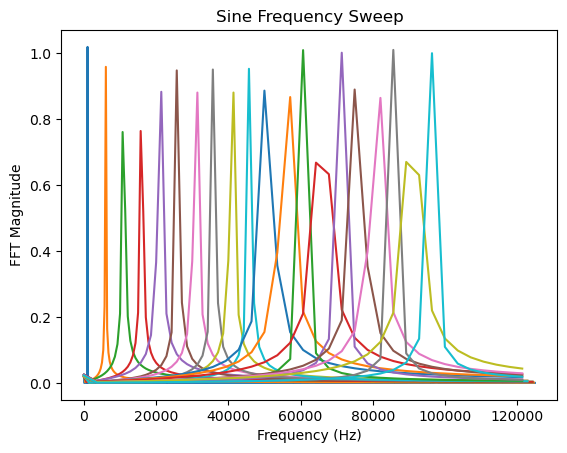

In [26]:
fig, ax = plt.subplots()
ax.set(title='Sine Frequency Sweep', xlabel='Frequency (Hz)', ylabel='FFT Magnitude')

freqs = np.arange(1e3, 100e3, 5e3)
f_start = 0
f_end = 125e3
set_wave_type(wavegen, 1, 'SINE')
set_amplitude(wavegen, 1, 2)
for wave_freq in freqs:
    # - set oscilloscope x-scale - #
    xscale = 1 / wave_freq
    set_xscale(oscope, xscale)

    # - set frequency, turn channel on - #
    set_frequency(wavegen, 1, wave_freq)
    set_channel_state(wavegen, 1, 'ON')

    # - capture data, run fft, plot - #
    T, t, data = scope_funcs.capture_data(oscope)
    f, fft_data = simple_fft(T, data)

    # - turn channel off before the next measurement
    set_channel_state(wavegen, 1, 'OFF')

    # - plot - #
    f_start_ind = np.argmin(np.abs(f - f_start))
    f_stop_ind = np.argmin(np.abs(f - f_end))
    ax.plot(f[f_start_ind:f_stop_ind], fft_data[f_start_ind:f_stop_ind])
    
    # - pause for a tenth of a second before next measurement
    time.sleep(0.5)
    